In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.externals import joblib
from sklearn.datasets import make_regression
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from collections import defaultdict

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import math
import inspect
import operator
pd.set_option('display.max_rows', 10000)

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Importing data, no TSS normalization performed here

In [3]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples that grouped with controls on PCoA

In [4]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

# Split by sampling location (soil v. skin)

## Soil sample filtering

In [5]:
Metab_soil = allMetab.filter_samples('sample_type', 'soil')
Metab_soil.sample_metadata.sample_type.value_counts()

soil    744
Name: sample_type, dtype: int64

In [6]:
print("Number of samples: ",len(Metab_soil.sample_metadata.metab_barcode.value_counts()))

Number of samples:  744


In [7]:
print("Number of bodies: ",len(Metab_soil.sample_metadata.subjectID.value_counts()))

Number of bodies:  36


# Soil General Model using ADD 0C as Response and Adding Metadata as Features

In [8]:
Metab_soil_meta = Metab_soil.add_sample_metadata_as_features(['facility','avg_percent_humidity','total_precipitation_cm'])
print("Number of features: ",len(Metab_soil_meta.feature_metadata))

Number of features:  4405


In [9]:
# designate data
X = Metab_soil_meta.data
y = Metab_soil_meta.sample_metadata['add_0c']
y = (y.astype(float))

# group by body
groups = Metab_soil_meta.sample_metadata['subjectID']

In [10]:
# outer_cv creates 36 folds by leave-one-body-out for estimating generalization error
outer_cv = LeaveOneGroupOut().split(X, y, groups=groups)

# prints the number of folds in the outer loop
print("Number of outer folds to perform: ", LeaveOneGroupOut().get_n_splits(X, y, groups=groups))

# hyperparameter grid to test
#param_grid = {"max_depth": [None, 4],
#              "max_features": ['auto', 0.2],
#              "bootstrap": [True, False]}

param_grid = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# creates loop iteration counter and empty lists for storage
count=1
model_parameters = []
nested_cv_scores = []

# loops through the sets of training and test ids in the outer loop
# the number of loops will match the number of folds as each fold is used
for train_ids, test_ids in outer_cv:
    # inner_cv creates 35 folds by leave-one-body-out for hyperparamter tuning
    # uses only the train ids present in the current outer loop fold which is one less body since the outer loop
    # folds are also using leave-one-body-out
    inner_cv = LeaveOneGroupOut().split(X[train_ids, :], y.iloc[train_ids], groups=groups[train_ids])
    # setting rf parameters
    rf = RandomForestRegressor(n_estimators=100, random_state=999, criterion='mae')
    # grid search cv using rf and the hyperparameter grid on the inner_cv training set
    rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, n_jobs=-1, scoring='neg_mean_absolute_error')
    # fit the grid search model on the inner_cv training set, which will tell us the best
    # parameters chosen by that inner cv
    rf_grid.fit(X[train_ids, :], y.iloc[train_ids])
    # converts best params dict to string to save it
    res = ",".join(("{}={}".format(*i) for i in rf_grid.best_params_.items()))
    # attaches each loops best params
    model_parameters.append(res)
    # prints outer fold number the loop is currently on
    print("Outer fold:",count)
    # prints number of inner folds in the outer loop (should be the same each time at 35)
    print("Number of inner folds:",LeaveOneGroupOut().get_n_splits(X[train_ids, :], y.iloc[train_ids], groups=groups[train_ids]))
    # prints best param and CV score from this inner loop set 
    print("Best params:",rf_grid.best_params_)
    print("Best CV score (MAE):",-rf_grid.best_score_)
    # uses the best model created from the inner loop to predict the outer loop body left out
    yhat = rf_grid.predict(X[test_ids,:])
    MAE = mean_absolute_error(y.iloc[test_ids], yhat)
    print("Prediction score (MAE):",MAE)
    nested_cv_scores.append(MAE)
    print("*****")
    count+=1
# prints the mean of the nested cv score (generalization error) of the models
print("\nNested CV score (generalization error): " + str(np.mean(nested_cv_scores)))

Number of outer folds to perform:  36
Outer fold: 1
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 84.96649849218518
Prediction score (MAE): 58.13164722316251
*****
Outer fold: 2
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 84.49732895130842
Prediction score (MAE): 79.57058611363253
*****
Outer fold: 3
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 83.54982079965126
Prediction score (MAE): 90.39730158671905
*****
Outer fold: 4
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 83.12822194823869
Prediction score (MAE): 61.07284391468333
*****
Outer fold: 5
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 80.5694617927097
Prediction score (MAE

In [12]:
# define function to merge 2 lists as paired tuples    
def merge(list1, list2): 
    merged_list = tuple(zip(list1, list2))  
    return merged_list 

# merge parameters to nested scores as tuples
merged_list = merge(model_parameters, nested_cv_scores)

# puts the paired tuple list into a dictionary
params_and_scores = defaultdict(list)
for k, v in merged_list:
    params_and_scores[k].append(v)

In [13]:
# prints dict of params and scores, should see each set of parameters chosen and their scores
params_and_scores

defaultdict(list,
            {'bootstrap=False,max_depth=4,max_features=0.1': [54.9093194454,
              69.80141666924999,
              93.30321428509524,
              57.30058201021428,
              167.53939153283335,
              143.62247353983335,
              91.52689153209523,
              96.49211640185712,
              112.19429894030955,
              86.8714027777,
              61.937552911309524,
              48.27908333295,
              48.99697090033334,
              42.89076719726191,
              47.7273015867619,
              55.77719576095238,
              65.4725694437,
              80.4215873002381,
              73.01075396816667,
              86.48727777799999,
              62.63869047861906,
              181.36980158640478,
              147.6104084962353,
              71.45264550526191,
              57.831640206285705,
              59.51197089338094,
              52.05019841557144,
              63.05033068995237,
              60.4858

In [14]:
# create a dict to assign the mean score to each param set
avgDict = {}
for k,v in params_and_scores.items():
    avgDict[k] = sum(v)/ float(len(v))
print(avgDict)

{'bootstrap=False,max_depth=4,max_features=0.1': 81.65359364666243}


In [23]:
# prints the param set with the best mean error
print("Best params:",max(avgDict, key=avgDict.get))
print("Best mean score:",max(avgDict.values()))

Best params: bootstrap=False,max_depth=4,max_features=0.1
Best mean score: 81.65359364666243


In [24]:
# input the best parameter set
best_model_params = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(rf, best_model_params, cv=LeaveOneGroupOut().split(X, y, groups=groups), scoring='neg_mean_absolute_error', n_jobs=-1)
final_regressor.fit(X, y)
print("Best CV score:",-final_regressor.best_score_)

Best CV score: -81.65359364666246


In [25]:
joblib.dump(final_regressor.best_estimator_, 'models/PMI3_Metab_soil_meta_general.pkl')

['models/PMI3_Metab_soil_meta_general.pkl']

In [26]:
model_Metab_soil_meta = joblib.load('models/PMI3_Metab_soil_meta_general.pkl')

In [27]:
model_Metab_soil_meta

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=4, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

### Determine important features

In [28]:
importances = model_Metab_soil_meta.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_soil_meta.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_soil_meta.feature_metadata
np.savetxt("feature_metadata/general_soil_feature_metadata_meta.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
general_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    general_importances += (Metab_soil_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_soil_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X300.288733742453_4.75564670033669	0.26384788680421395
2. X282.27712487174_7.23317913752913	0.16956385653172668
3. X265.251858191667_7.72115745216515	0.0695014486247381
4. X317.207511159171_6.03750368731563	0.06221729093935518
5. X283.261846131269_6.46965379294957	0.04735563405787485
6. X256.262006528934_7.07576439121756	0.02504825387301515
7. X377.324868937802_6.77922911373261	0.024434758648755415
8. X277.213423203688_7.13919135897436	0.01926142042936674
9. X281.246612658867_7.30952552083333	0.01859250918704217
10. X393.20879965785_2.43590272289767	0.016757291839104203
11. X501.157281666678_2.25135068708284	0.016592826065744214
12. X255.231118649466_7.12408511166254	0.01657346248897237
13. X283.262279643568_7.70306372739017	0.011937852338557283
14. X117.091183609983_3.40778691183754	0.010168412065838019
15. X247.16604482941_9.94318677098151	0.008700158537218497
16. facility=CMU	0.008678317385967077
17. X328.283489266621_6.07409948453607	0.00792424361437542
1

In [29]:
print("Number of features present:", int(len(general_importances)/2))
general_importances_df = pd.DataFrame(np.array(general_importances).reshape(int(len(general_importances)/2),2))

np.savetxt("importances/general_soil_importances_meta.csv", general_importances_df, delimiter=",", fmt='%s')

Number of features present: 4405


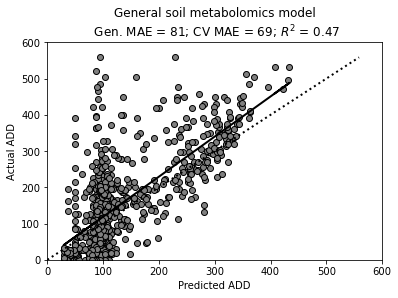

In [30]:
yhat = model_Metab_soil_meta.predict(X)
MAE = mean_absolute_error(y, yhat)

plt.scatter(yhat, y, color = 'lightgray', edgecolors = 'black')
lower = np.min(np.concatenate([y, yhat]))
upper = np.max(np.concatenate([y, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General soil metabolomics model\n Gen. MAE = %d; MAE = %d; $R^2$ = %.2f' %(np.mean(nested_cv_scores),MAE,round(model_Metab_soil_meta.score(X,y),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_soil_model.png')